<a href="https://colab.research.google.com/github/Crepopcorn/sit_detection_project/blob/main/drowsiness-efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.9.1

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/My Drive/PreparedData/Train'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Compile data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)
df

,filepaths,labels
0,/content/drive/My Drive/PreparedData/Train/Ope...,Opened
1,/content/drive/My Drive/PreparedData/Train/Ope...,Opened
2,/content/drive/My Drive/PreparedData/Train/Ope...,Opened
3,/content/drive/My Drive/PreparedData/Train/Ope...,Opened
4,/content/drive/My Drive/PreparedData/Train/Ope...,Opened
...,...,...
4227,/content/drive/My Drive/PreparedData/Train/Clo...,Closed
4228,/content/drive/My Drive/PreparedData/Train/Clo...,Closed
4229,/content/drive/My Drive/PreparedData/Train/Clo...,Closed
4230,/content/drive/My Drive/PreparedData/Train/Clo...,Closed


In [5]:
data_dir = '/content/drive/My Drive/PreparedData/Train'

In [6]:
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [7]:
df

,filepaths,labels
0,/content/drive/My Drive/PreparedData/Train/Ope...,Opened
1,/content/drive/My Drive/PreparedData/Train/Ope...,Opened
2,/content/drive/My Drive/PreparedData/Train/Ope...,Opened
3,/content/drive/My Drive/PreparedData/Train/Ope...,Opened
4,/content/drive/My Drive/PreparedData/Train/Ope...,Opened
...,...,...
4227,/content/drive/My Drive/PreparedData/Train/Clo...,Closed
4228,/content/drive/My Drive/PreparedData/Train/Clo...,Closed
4229,/content/drive/My Drive/PreparedData/Train/Clo...,Closed
4230,/content/drive/My Drive/PreparedData/Train/Clo...,Closed


In [8]:
# train dataframe
train_df, valid_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42)

In [10]:
# Generate data paths with labels
data_dir = '/content/drive/My Drive/PreparedData/Test'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [11]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 3385 validated image filenames belonging to 2 classes.
Found 847 validated image filenames belonging to 2 classes.
Found 904 validated image filenames belonging to 2 classes.


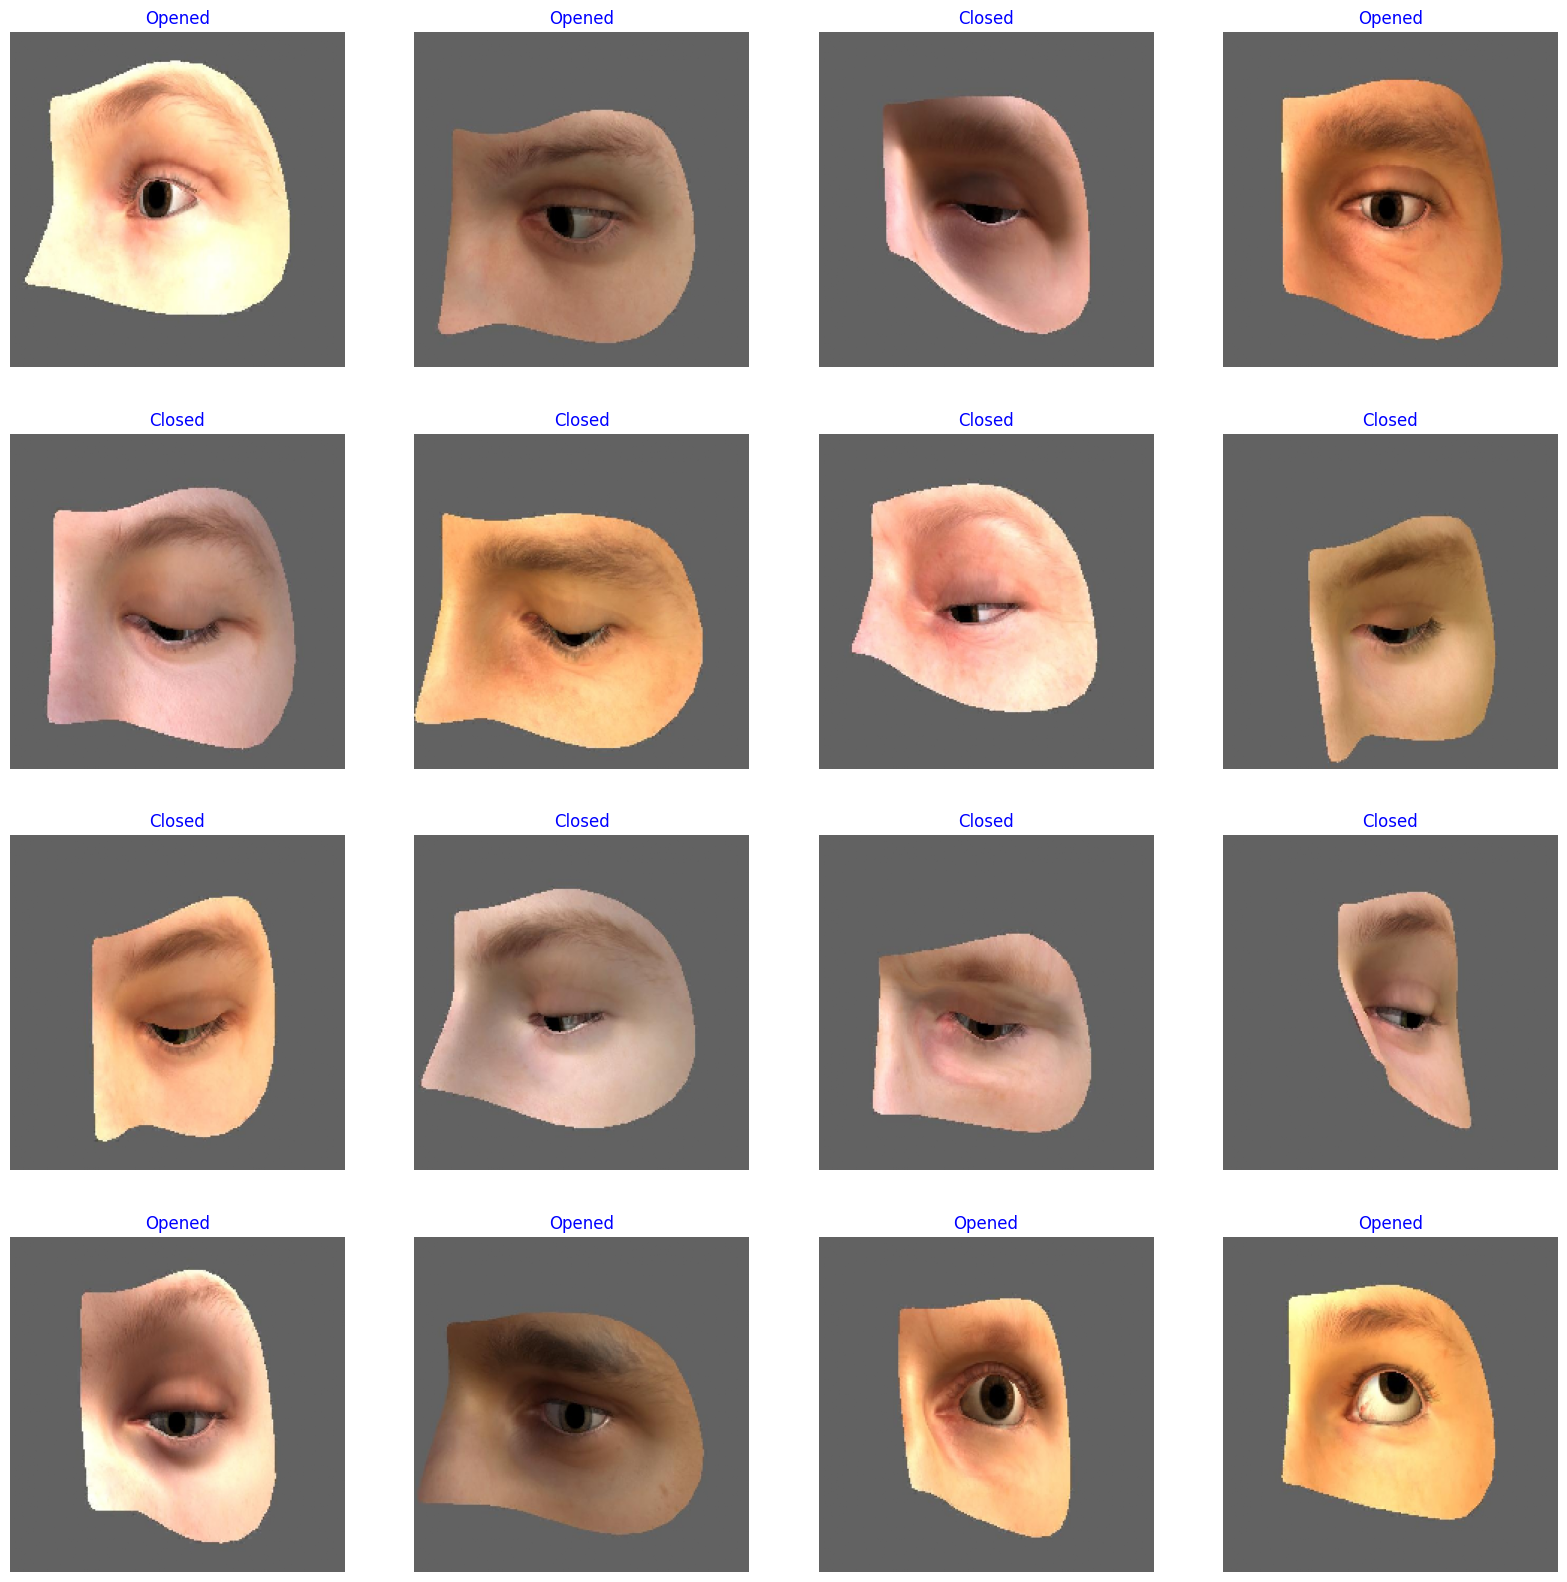

In [12]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)      #plot image in 4 columns per row
    image = images[i] / 255       # scales ranging within 0 - 255
    plt.imshow(image)             # plot image
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [13]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# Using use efficientnetb0 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False,
                                                               weights= "imagenet",
                                                               input_shape= img_shape,
                                                               pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 42),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

16705208/16705208 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 4,383,141
Trainable params: 4,338,558
Non-t

In [14]:
batch_size = 16   # set batch size for training
epochs = 30   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/30
212/212 [==============================] - 1555s 7s/step - loss: 5.2841 - accuracy: 0.9126 - val_loss: 3.6584 - val_accuracy: 0.9646
Epoch 2/30
212/212 [==============================] - 122s 575ms/step - loss: 2.8239 - accuracy: 0.9542 - val_loss: 2.2669 - val_accuracy: 0.9504
Epoch 3/30
212/212 [==============================] - 122s 575ms/step - loss: 1.7744 - accuracy: 0.9690 - val_loss: 1.5187 - val_accuracy: 0.9244
Epoch 4/30
212/212 [==============================] - 122s 577ms/step - loss: 1.1950 - accuracy: 0.9725 - val_loss: 0.9976 - val_accuracy: 0.9705
Epoch 5/30
212/212 [==============================] - 122s 576ms/step - loss: 0.8152 - accuracy: 0.9808 - val_loss: 0.7438 - val_accuracy: 0.9587
Epoch 6/30
212/212 [==============================] - 122s 577ms/step - loss: 0.5877 - accuracy: 0.9820 - val_loss: 0.5188 - val_accuracy: 0.9752
Epoch 7/30
212/212 [==============================] - 122s 575ms/step - loss: 0.4217 - accuracy: 0.9852 - val_loss: 0.3898 - v

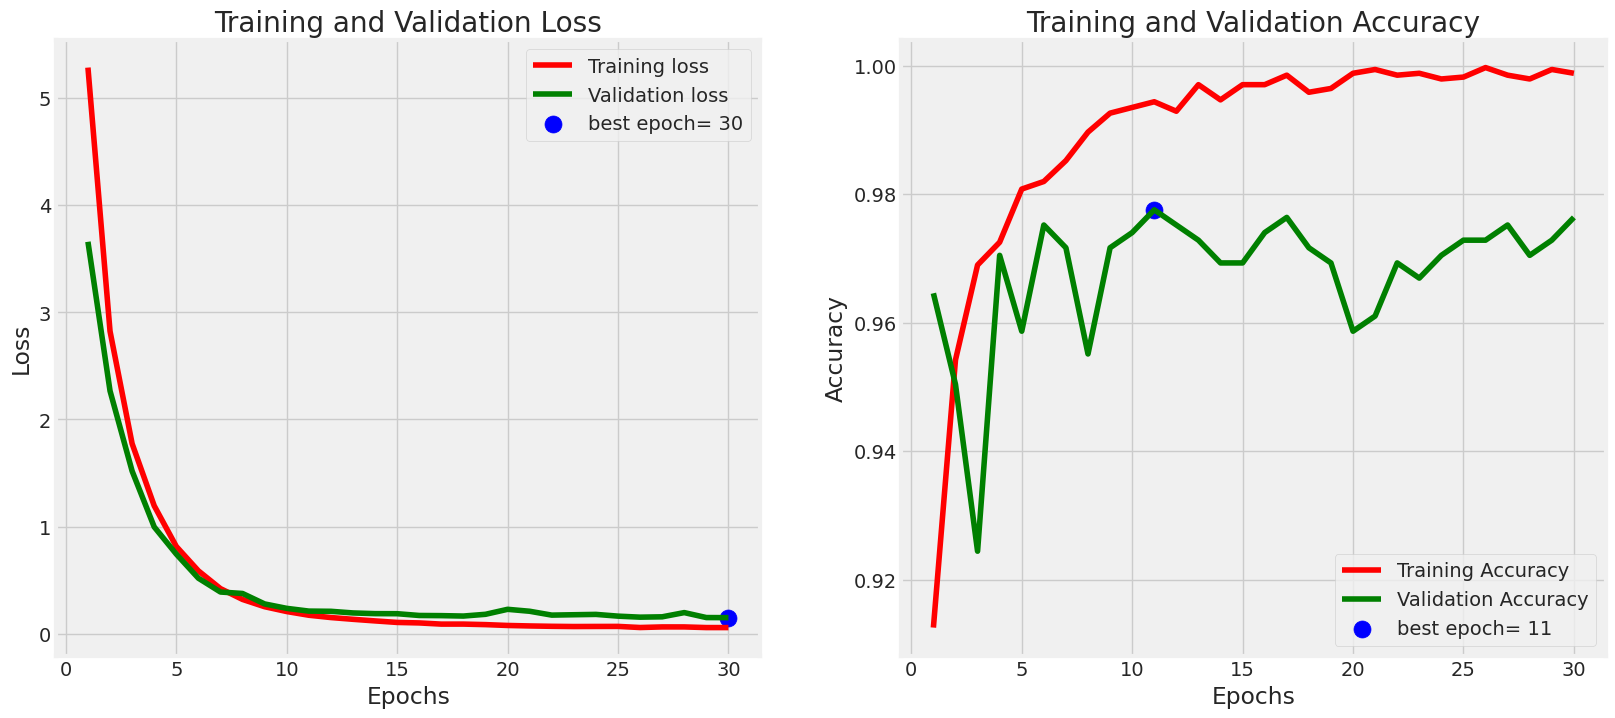

In [15]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [16]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

 53/113 [=============>................] - ETA: 10s - loss: 0.1506 - accuracy: 0.9764

113/113 [==============================] - 676s 6s/step - loss: 0.1718 - accuracy: 0.9723
Train Loss:  0.04427844285964966
Train Accuracy:  1.0
--------------------
Validation Loss:  0.15055309236049652
Validation Accuracy:  0.9763872623443604
--------------------
Test Loss:  0.1718064397573471
Test Accuracy:  0.9723451137542725


In [23]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

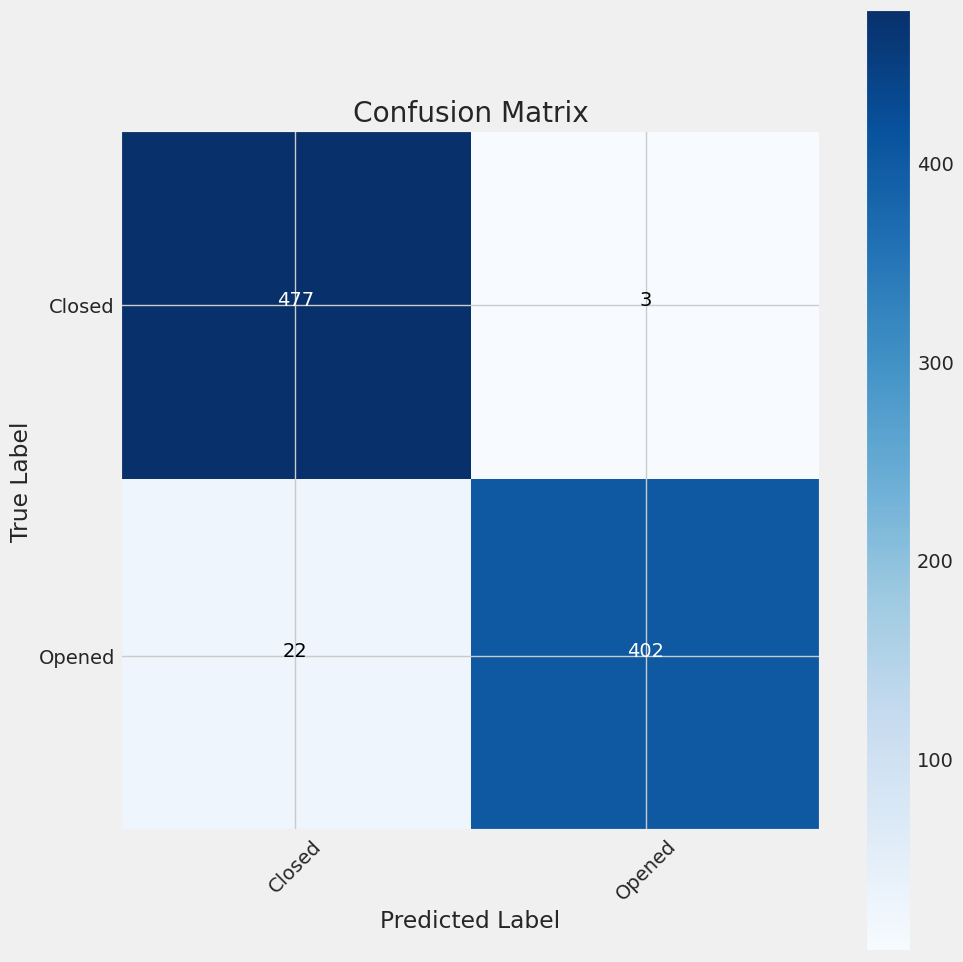

In [24]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [25]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      Closed       0.96      0.99      0.97       480
      Opened       0.99      0.95      0.97       424

    accuracy                           0.97       904
   macro avg       0.97      0.97      0.97       904
weighted avg       0.97      0.97      0.97       904



In [26]:
model.save('/content/drive/My Drive/temp/real_eyes.h5')